# 数据准备

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## 加载数据

In [6]:
DATA_STORE = Path('..', 'data', 'assets_cn.h5')

In [43]:
with pd.HDFStore(DATA_STORE) as store:
    data = (store['bao/prices']
            .loc[idx[:, :],
                 ['open', 'high', 'low', 'close', 'volume']]
            .dropna()
            .swaplevel()
            .sort_index())
        #     .rename(columns=lambda x: x.replace('adj_', '')))
    metadata = store['cn_equities/stocks'].loc[:, ['code_name', 'mktcap', 'industry']]

In [44]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 401535 entries, ('sh.600000', Timestamp('2017-07-03 00:00:00')) to ('sz.300999', Timestamp('2023-06-21 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    401535 non-null  float64
 1   high    401535 non-null  float64
 2   low     401535 non-null  float64
 3   close   401535 non-null  float64
 4   volume  401535 non-null  float64
dtypes: float64(5)
memory usage: 16.9+ MB


In [45]:
metadata["sector"] = pd.factorize(metadata.industry)[0]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, sh.600000 to sz.300999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   code_name  300 non-null    object 
 1   mktcap     300 non-null    float64
 2   industry   300 non-null    object 
 3   sector     300 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 11.7+ KB


In [46]:
metadata.head()

,code_name,mktcap,industry,sector
code,,,,
sh.600000,浦发银行,2.132478e+09,银行,0
sh.600009,上海机场,9.112023e+08,交通运输,1
sh.600010,包钢股份,5.638047e+08,钢铁,2
sh.600011,华能国际,9.721776e+08,公用事业,3
sh.600015,华夏银行,6.898468e+08,银行,0


In [47]:
data = data.join(metadata).dropna(subset=['sector'])

In [48]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 401535 entries, ('sh.600000', Timestamp('2017-07-03 00:00:00')) to ('sz.300999', Timestamp('2023-06-21 00:00:00'))
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   open       401535 non-null  float64
 1   high       401535 non-null  float64
 2   low        401535 non-null  float64
 3   close      401535 non-null  float64
 4   volume     401535 non-null  float64
 5   code_name  401535 non-null  object 
 6   mktcap     401535 non-null  float64
 7   industry   401535 non-null  object 
 8   sector     401535 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 29.2+ MB


In [49]:
data.tail()

open   high    low  close     volume code_name  \
code      date                                                          
sz.300999 2023-06-15  40.90  41.20  40.60  41.20  6555324.0       金龙鱼   
          2023-06-16  41.20  41.46  41.02  41.34  5439501.0       金龙鱼   
          2023-06-19  41.25  41.50  40.91  40.94  4766000.0       金龙鱼   
          2023-06-20  41.22  41.22  40.68  40.79  3700416.0       金龙鱼   
          2023-06-21  40.60  40.78  40.23  40.23  4111032.0       金龙鱼   

                            mktcap industry  sector  
code      date                                       
sz.300999 2023-06-15  2.183036e+08     农林牧渔      23  
          2023-06-16  2.183036e+08     农林牧渔      23  
          2023-06-19  2.183036e+08     农林牧渔      23  
          2023-06-20  2.183036e+08     农林牧渔      23  
          2023-06-21  2.183036e+08     农林牧渔      23

In [50]:
print(f"# 股票总数: {len(data.index.unique('code')):,.0f} | # 时间数据: {len(data.index.unique('date')):,.0f}")

# 股票总数: 300 | # 时间数据: 1,453


## 选择 50 只交易量最大的股票

In [54]:
dv = data.close.mul(data.volume)

In [56]:
top50 = (dv.groupby(level='date')
          .rank(ascending=False)
          .unstack('code')
          .dropna(axis=1)
          .mean()
          .nsmallest(50))

In [33]:
top50.count()

50

### 可视化 20 只最具流动性的股票

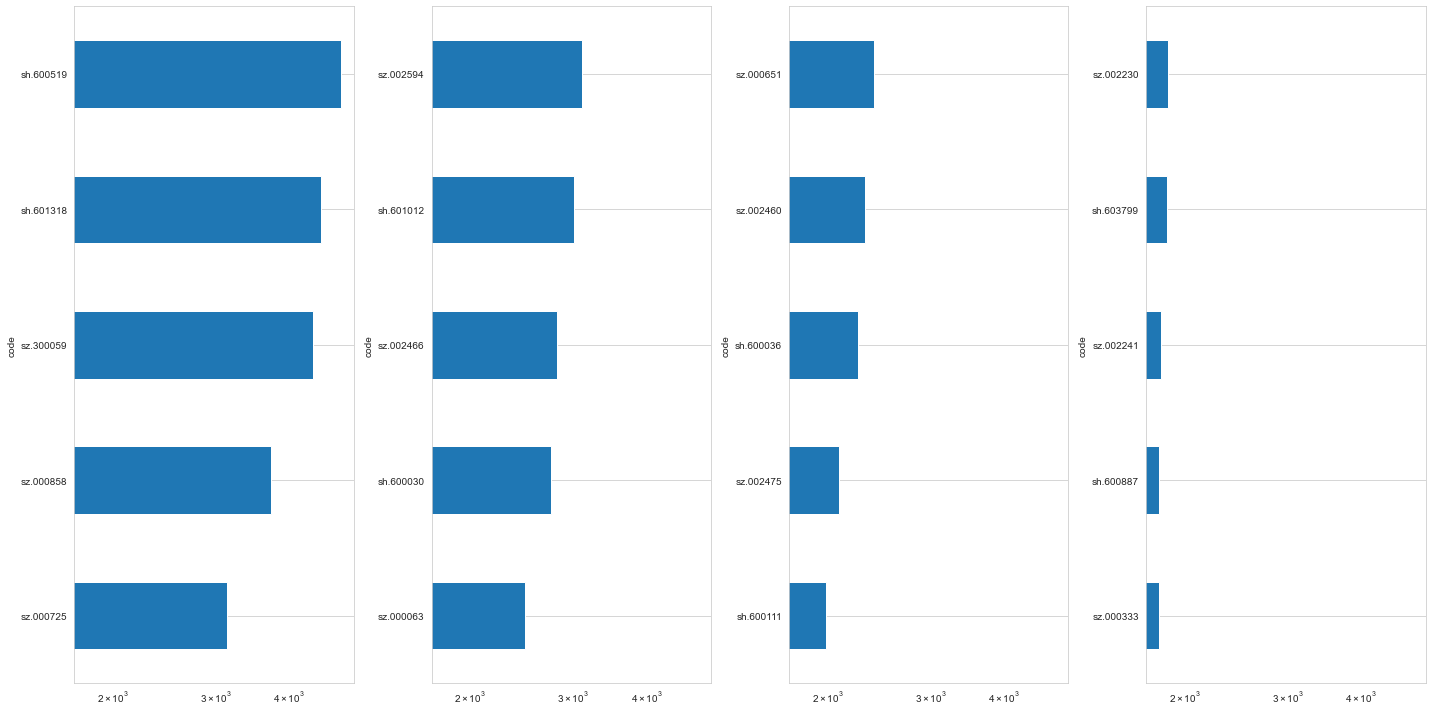

In [58]:
top20 = (data.close
          .mul(data.volume)
          .unstack('code')
          .dropna(axis=1)
          .mean()
          .div(1e6)
          .nlargest(200))
cutoffs = [0, 5, 10, 15, 20]
fig, axes = plt.subplots(ncols=4, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, cutoff in enumerate(cutoffs[1:], 1):
    top20.iloc[cutoffs[i-1]:cutoffs[i]
                ].sort_values().plot.barh(logx=True, ax=axes[i-1])
fig.tight_layout()

In [59]:
to_drop = data.index.unique('code').difference(top50.index)

In [60]:
len(to_drop)

250

In [61]:
data = data.drop(to_drop, level='code')

In [62]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72650 entries, ('sh.600030', Timestamp('2017-07-03 00:00:00')) to ('sz.300274', Timestamp('2023-06-21 00:00:00'))
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       72650 non-null  float64
 1   high       72650 non-null  float64
 2   low        72650 non-null  float64
 3   close      72650 non-null  float64
 4   volume     72650 non-null  float64
 5   code_name  72650 non-null  object 
 6   mktcap     72650 non-null  float64
 7   industry   72650 non-null  object 
 8   sector     72650 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 5.3+ MB


In [64]:
print(f"# 股票数: {len(data.index.unique('code')):,.0f} | # 数据长度: {len(data.index.unique('date')):,.0f}")

# 股票数: 50 | # 数据长度: 1,453


### 根据每日回报删除异常值观察结果

In [65]:
before = len(data)
data['ret'] = data.groupby('code').close.pct_change()
data = data[data.ret.between(-1, 1)].drop('ret', axis=1)
print(f'Dropped {before-len(data):,.0f}')

Dropped 50


In [66]:
tickers = data.index.unique('code')
print(f"# 股票数: {len(tickers):,.0f} | # 数据长度: {len(data.index.unique('date')):,.0f}")

# 股票数: 50 | # 数据长度: 1,452


### 用于说明的示例价格数据

In [69]:
data.head()

open   high    low  close       volume code_name  \
code      date                                                            
sh.600030 2017-07-04  16.89  16.89  16.68  16.73   72789645.0      中信证券   
          2017-07-05  16.75  16.89  16.70  16.87   59509848.0      中信证券   
          2017-07-06  16.90  16.93  16.65  16.73   86394887.0      中信证券   
          2017-07-07  16.68  17.05  16.60  16.95   89463500.0      中信证券   
          2017-07-10  16.93  17.23  16.91  17.01  110150632.0      中信证券   

                            mktcap industry  sector  
code      date                                       
sh.600030 2017-07-04  2.256381e+09     非银金融       5  
          2017-07-05  2.256381e+09     非银金融       5  
          2017-07-06  2.256381e+09     非银金融       5  
          2017-07-07  2.256381e+09     非银金融       5  
          2017-07-10  2.256381e+09     非银金融       5

In [70]:
ticker = 'sh.600030'
# alternative
# ticker = np.random.choice(tickers)
price_sample = data.loc[idx[ticker, :], :].reset_index('code', drop=True)

In [71]:
price_sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1452 entries, 2017-07-04 to 2023-06-21
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1452 non-null   float64
 1   high       1452 non-null   float64
 2   low        1452 non-null   float64
 3   close      1452 non-null   float64
 4   volume     1452 non-null   float64
 5   code_name  1452 non-null   object 
 6   mktcap     1452 non-null   float64
 7   industry   1452 non-null   object 
 8   sector     1452 non-null   int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 113.4+ KB


In [72]:
price_sample.to_hdf('cn_data.h5', 'data/sample')

## 计算回报

按股票进行分组

In [73]:
by_ticker = data.groupby(level='code')

### 历史回报

In [74]:
T = [1, 2, 3, 4, 5, 10, 21, 42, 63, 126, 252]

In [75]:
for t in T:
    data[f'ret_{t:02}'] = by_ticker.close.pct_change(t)

### 远期回报

In [76]:
data['ret_fwd'] = by_ticker.ret_01.shift(-1)
data = data.dropna(subset=['ret_fwd'])

## 保留结果

In [77]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72550 entries, ('sh.600030', Timestamp('2017-07-04 00:00:00')) to ('sz.300274', Timestamp('2023-06-20 00:00:00'))
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       72550 non-null  float64
 1   high       72550 non-null  float64
 2   low        72550 non-null  float64
 3   close      72550 non-null  float64
 4   volume     72550 non-null  float64
 5   code_name  72550 non-null  object 
 6   mktcap     72550 non-null  float64
 7   industry   72550 non-null  object 
 8   sector     72550 non-null  int64  
 9   ret_01     72500 non-null  float64
 10  ret_02     72450 non-null  float64
 11  ret_03     72400 non-null  float64
 12  ret_04     72350 non-null  float64
 13  ret_05     72300 non-null  float64
 14  ret_10     72050 non-null  float64
 15  ret_21     71500 non-null  float64
 16  ret_42     70450 non-null  float64
 17  ret_63     69400 non-null  float64
 18

In [78]:
data.to_hdf('cn_data.h5', 'data/top50')